In [30]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [31]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [33]:
from subgradient_mae import compute_subgradient_mae
w = np.array([1,2]).T

print(compute_subgradient_mae(y, tx, w))



[-1.00000000e+00  2.21853647e-15]


In [3]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_loss` function below:

In [4]:
def compute_loss(y, tx, w):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    #MSE loss is (1/2*N)(e')(e)
    #where e = y-Xw
    e = y - tx*w
    return (1/(2*y.shape[0]))*e.T*e


# 2. Grid Search

Fill in the function `grid_search()` below:

In [21]:
# from costs import *
from costs import compute_loss_mae

def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))
    
    for i in range(grid_w0.shape[0]):
        for j in range(grid_w1.shape[0]):
            losses[i, j] = compute_loss_mae(y, tx, np.array([grid_w0[i], grid_w1[j]])) 
    
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=4.442174461519979, w0*=73.1543624161074, w1*=13.087248322147673, execution time=0.792 seconds


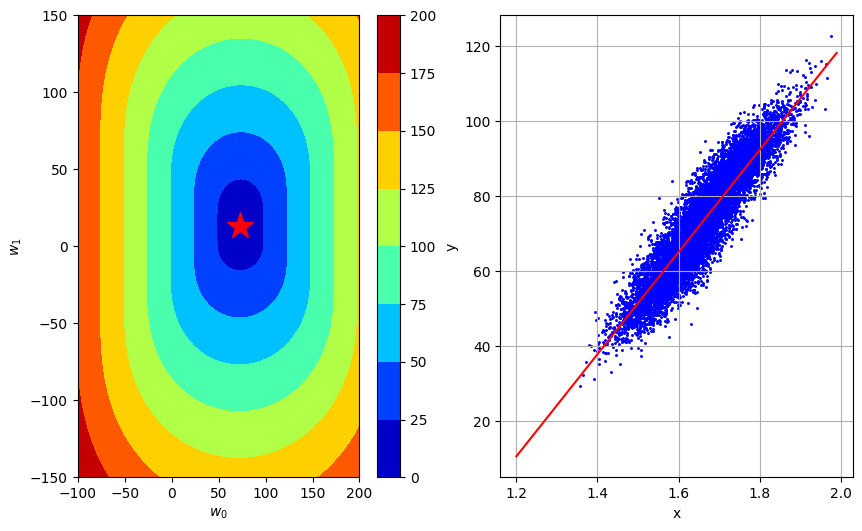

In [22]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=150)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
fig.savefig("grid_plot")  # Optional saving

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [7]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """

    #Given the loss is the MSE. I will compute the MSE gradient
    #The gradient of the MSE = -1/N * tx' * (y-txw)
    gradient = (-1/y.shape[0]) * (tx.T @ (y - tx@w))

    return gradient



Please fill in the functions `gradient_descent` below:

In [8]:
from numpy import gradient
from costs import compute_loss


def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        loss = compute_loss(y, tx, w)
        gradient = compute_gradient(y, tx, w)
        w = w - gamma*gradient

        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

GD iter. 0/99: loss=2792.236712759168, w0=51.30574540147361, w1=9.435798704492278
GD iter. 1/99: loss=265.30246210896047, w0=66.69746902191571, w1=12.266538315840002
GD iter. 2/99: loss=37.87837955044127, w0=71.31498610804834, w1=13.11576019924433
GD iter. 3/99: loss=17.41021212017447, w0=72.70024123388814, w1=13.37052676426563
GD iter. 4/99: loss=15.568077051450455, w0=73.11581777164007, w1=13.446956733772023
GD iter. 5/99: loss=15.402284895265298, w0=73.24049073296565, w1=13.469885724623941
GD iter. 6/99: loss=15.38736360120863, w0=73.27789262136334, w1=13.476764421879516
GD iter. 7/99: loss=15.386020684743533, w0=73.28911318788263, w1=13.478828031056189
GD iter. 8/99: loss=15.38589982226167, w0=73.29247935783842, w1=13.47944711380919
GD iter. 9/99: loss=15.385888944638303, w0=73.29348920882516, w1=13.47963283863509
GD iter. 10/99: loss=15.385887965652207, w0=73.29379216412119, w1=13.479688556082861
GD iter. 11/99: loss=15.385887877543452, w0=73.29388305071, w1=13.479705271317192
GD 

/tmp/ipykernel_105253/1953344682.py:18: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(np.arange(0, max_iters, 1)), np.log10(gd_losses))


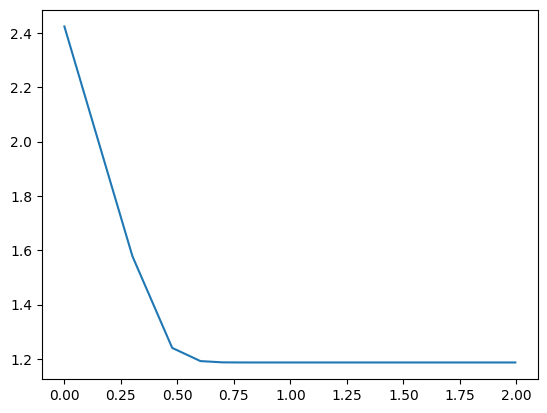

GD: execution time=0.034 seconds


In [9]:
# from gradient_descent import *
from plots import gradient_descent_visualization

import matplotlib.pyplot as plt

# Define the parameters of the algorithm.
max_iters = 100
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

plt.plot(np.log10(np.arange(0, max_iters, 1)), np.log10(gd_losses))
plt.show()


# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

In [12]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=101, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# 4. Stochastic gradient descent

In [10]:
from helpers import *

def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """
    #This computes the gradient over a mini-batch of size B
    #Given the loss is the MSE. I will compute the MSE gradient
    #The gradient of the MSE = -1/B * tx' * (y-txw)
    gradient = (-1/y.shape[0]) * (tx.T @ (y - tx@w))

    return gradient


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        for y_batch, tx_batch in batch_iter(y, tx, batch_size):           
            loss = compute_loss(y_batch, tx_batch, w)
            gradient = compute_gradient(y_batch, tx_batch, w)
            w = w - gamma*gradient
        
        ws.append(w)
        losses.append(loss)
        print(
            "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [11]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=1851.7661316691226, w0=6.0856653402386875, w1=-2.9505297833675463
Inner Loop ran:  1
SGD iter. 1/49: loss=1084.64386693279, w0=10.74322664833285, w1=-6.4020057332993305
Inner Loop ran:  1
SGD iter. 2/49: loss=5426.522161127156, w0=21.161021195286786, w1=16.999795659678757
Inner Loop ran:  1
SGD iter. 3/49: loss=1227.3194933184773, w0=26.11545253161284, w1=19.774253621911548
Inner Loop ran:  1
SGD iter. 4/49: loss=1086.7852709994245, w0=30.777609266428655, w1=16.251810709334308
Inner Loop ran:  1
SGD iter. 5/49: loss=586.2900156819519, w0=34.20190486021711, w1=22.087300133758042
Inner Loop ran:  1
SGD iter. 6/49: loss=564.7429690874895, w0=37.56268741518103, w1=22.416550962827
Inner Loop ran:  1
SGD iter. 7/49: loss=788.9136401661873, w0=41.53487482306145, w1=23.337124114919636
Inner Loop ran:  1
SGD iter. 8/49: loss=466.4876023746904, w0=44.58933910464894, w1=24.92790295068756
Inner Loop ran:  1
SGD iter. 9/49: loss=214.281875852337, w0=46.659517241198245, w1=26.99

In [13]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=1, min=1), Output()), _dom_classes=('widget…

<function __main__.plot_figure(n_iter)>

# 5. Effect of Outliers and MAE Cost Function

In [ ]:
import datetime
from helpers import *


height, weight, gender = load_data(True, False)

x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [ ]:
y.shape, tx.shape

In [18]:
#Testing to see if MAE works
from costs import compute_loss_mae

y = np.ones((5,))
x = np.array([[2, 2],[2, 2],[2, 2],[2, 2],[2, 2]])
w = np.ones((2,))

print(compute_loss_mae(y, x, w))

3.0


In [15]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()    

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: fit the model to the subsampled data / subsampled data with outliers and visualize the cloud of points
#       and the model fit
# ***************************************************
raise NotImplementedError


end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

ImportError: cannot import name 'compute_loss' from 'costs' (/mnt/c/Users/aaron/Desktop/Coding/CS-433/labs/ex02/solution/costs.py)

In [ ]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

# 6. Subgradient descent

In [ ]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    # ***************************************************
    
    e = y - tx @ w
    e_signs = np.sign(e)
    tx = np.multiply(tx, e_signs[:, np.newaxis])
    x_sum = np.sum(tx, axis=0)
    gradient = (1/y.shape[0]) * x_sum
    return gradient

In [12]:
from costs import compute_loss_mae
from subgradient_mae import compute_subgradient_mae

def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        loss = compute_loss_mae(y, tx, w)
        gradient = compute_subgradient_mae(y, tx, w)
        w = w - gamma*gradient

        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [28]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/499: loss=73.29392200210518, w0=10000.0, w1=-2.2185364656479578e-11
GD iter. 1/499: loss=9926.706077997895, w0=0.0, w1=0.0
GD iter. 2/499: loss=73.29392200210518, w0=10000.0, w1=-2.2185364656479578e-11
GD iter. 3/499: loss=9926.706077997895, w0=0.0, w1=0.0
GD iter. 4/499: loss=73.29392200210518, w0=10000.0, w1=-2.2185364656479578e-11
GD iter. 5/499: loss=9926.706077997895, w0=0.0, w1=0.0
GD iter. 6/499: loss=73.29392200210518, w0=10000.0, w1=-2.2185364656479578e-11
GD iter. 7/499: loss=9926.706077997895, w0=0.0, w1=0.0
GD iter. 8/499: loss=73.29392200210518, w0=10000.0, w1=-2.2185364656479578e-11
GD iter. 9/499: loss=9926.706077997895, w0=0.0, w1=0.0
GD iter. 10/499: loss=73.29392200210518, w0=10000.0, w1=-2.2185364656479578e-11
GD iter. 11/499: loss=9926.706077997895, w0=0.0, w1=0.0
GD iter. 12/499: loss=73.29392200210518, w0=10000.0, w1=-2.2185364656479578e-11
GD iter. 13/499: loss=9926.706077997895, w0=0.0, w1=0.0
GD iter. 14/499: loss=73.29392200210518, w0=10000.0, w1=-2

In [ ]:
from ipywidgets import IntSlider, interact
from plots import gradient_descent_visualization

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [ ]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Compute a stochastic subgradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic subgradient descent.
        # ***************************************************
        raise NotImplementedError

        print(
            "SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [ ]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

In [ ]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))